##  Creating the DB
This document is solely for testing localy, i am not sure if it can be applied to the current code but i will try my best to make it as compatible as possible

In [15]:
import sqlite3 
import os
import pandas as pd
import re
import unicodedata
import glob
import matplotlib.pyplot as plt

### "Pre processing" the data 
it would be great to have the file path with it in each data frame
(this is nearly identical to what Anna is doing)

In [16]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\farah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
df = pd.read_excel('content\ground_truth\data.xlsx')
ground_truth_df = df[['Study_ID', 'Study', 'Allocation', 'Experimenter']]
ground_truth_df

,Study_ID,Study,Allocation,Experimenter
0,1,Chacko et al 2017,Random,Parent
1,1,Chacko et al 2017,Random,Parent
2,2,Coyne et al 2004,Non-random,Teacher
3,2,Coyne et al 2004,Non-random,Teacher
4,3,Purpura et al 2017,Random,Researcher
...,...,...,...,...
311,54,Hassinger-Das (2013),Random,Researcher
312,54,Hassinger-Das (2013),Random,Researcher
313,54,Hassinger-Das (2013),Random,Researcher
314,27,Crandell 2010,Random,Teacher


In [18]:
# extracting data from the csv files in the extracted directory
def extract_df_from_csv(extracted_dir):
    """
    Loads all CSV files from the given directory into a combined DataFrame.
    Args:
        extracted_dir (str): Path to the directory containing CSV files.
    Returns:
        pd.DataFrame: Combined DataFrame of all loaded CSV files.
    """
    errorLoadingCount = 0
    extracted_dfs = []
    print(f"Extracting data from CSV files in directory: {extracted_dir}")
    if os.path.exists(extracted_dir):
        for filename in os.listdir(extracted_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(extracted_dir, filename)
                try:
                    df = pd.read_csv(file_path)
                    extracted_dfs.append(df)
                    #print(f"Loaded {filename}")
                except Exception as e:
                    #print(f"Failed to load {filename}: {e}")
                    #print(f"Error loading file : {e}")
                    errorLoadingCount += 1
        if errorLoadingCount > 0:
            print(f"Total files not loaded : {errorLoadingCount}")

    if extracted_dfs:
        extracted_combined_df = pd.concat(extracted_dfs, ignore_index=True)
        print("Combined DataFrame created.")
        print(f"Total rows in combined DataFrame: {len(extracted_combined_df)}")
        print("-"* 40)
        return extracted_combined_df
    else:
        print("No CSV files found in the directory.")
        return pd.DataFrame()

In [19]:
#extracts data from all csv in all directories matching the pattern
def extract_data_from_csv_in_dir(ext_splitted = [], directory='content/extracted_*'):
    # Get all directory names matching the pattern
    ext_splitted_dir = [d for d in glob.glob(directory) if os.path.isdir(d)]

    for dir in ext_splitted_dir:
        if os.path.exists(dir):
            print(f"Extracted data from {dir}")
            ext_splitted.append({'dir': dir, 'data': extract_df_from_csv(dir)})

In [20]:
ext_splitted = []
extract_data_from_csv_in_dir(ext_splitted, directory='content/extracted_*')

extracted_combined_df = extract_df_from_csv('content/extracted')

Extracted data from content\extracted_split_1_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_1_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\

In [21]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def format_studyName(study_name_string):
    """
    Cuts a string after the last four-digit number, assuming it represents the year.

    Args:
        study_name_string (str): The input string potentially containing a year.

    Returns:
        str: The string cut after the year, or the original string if no year is found.
    """
    # Get rid of all the points, -
    study_name_string = study_name_string.replace('.', '')
    study_name_string = study_name_string.replace(',', '')
    study_name_string = study_name_string.replace(' - ', ' ')
    study_name_string = study_name_string.replace(')', '')
    study_name_string = study_name_string.replace('(', '')
    study_name_string = study_name_string.replace('&', 'and')
    study_name_string = remove_accents(study_name_string)
    # Find all occurrences of four consecutive digits (potential years)
    year_matches = list(re.finditer(r'\b\d{4}\b', study_name_string))

    if year_matches:
        # Get the last match
        last_year_match = year_matches[-1]
        # Get the end index of the last year match
        end_of_year_index = last_year_match.end()
        # Slice the string up to the end of the year
        cut_string = study_name_string[:end_of_year_index]
        return cut_string.strip() # Use strip to remove trailing whitespace
    else:
        # If no four-digit number is found, return the original string
        return study_name_string.strip()
    
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          #print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

In [22]:
def accuracyCheck_alloc_and_exp(extracted_combined_df, ground_truth_df):
    accuracy_check('Allocation', extracted_combined_df, ground_truth_df)
    accuracy_check('Experimenter', extracted_combined_df, ground_truth_df)

def format_name_and_accuracy_check(ext_splitted, ground_truth_df):
    """loops through the extracted data, formats the study names and checks accuracy.
    Args:
        ext_splitted (list): List of dictionaries containing extracted data and directory names.
        ground_truth_df (pd.DataFrame): DataFrame containing ground truth data for accuracy checks.
    """
    for ext in ext_splitted:
        accuracyCheck_alloc_and_exp(ext['data'], ground_truth_df)
        ext['data']['Study'] = ext['data']['Study'].apply(format_studyName)
        print(f"Formatted Study names in {ext['dir']}")
        #accuracy_check('Allocation', ext['data'], ground_truth_df)
        #accuracy_check('Experimenter', ext['data'], ground_truth_df)


In [23]:
ext_splitted = []
extract_data_from_csv_in_dir(ext_splitted, directory='content/extracted_*')

#TODO : run the new results
format_name_and_accuracy_check(ext_splitted, ground_truth_df) #does it for all tables from a dir
accuracyCheck_alloc_and_exp(extracted_combined_df, ground_truth_df) #does it on a single df

Extracted data from content\extracted_split_1_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_1_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 18
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 17
----------------------------------------
Extracted data from content\

In [24]:
lab_results_dir = 'content/lab_results/*'
lab_results = []
extract_data_from_csv_in_dir(lab_results, directory=lab_results_dir)

Extracted data from content/lab_results\extracted_examples_4_shuffle_1
Extracting data from CSV files in directory: content/lab_results\extracted_examples_4_shuffle_1


Total files not loaded : 10
Combined DataFrame created.
Total rows in combined DataFrame: 19
----------------------------------------
Extracted data from content/lab_results\extracted_examples_4_shuffle_2
Extracting data from CSV files in directory: content/lab_results\extracted_examples_4_shuffle_2
Total files not loaded : 9
Combined DataFrame created.
Total rows in combined DataFrame: 20
----------------------------------------
Extracted data from content/lab_results\extracted_examples_4_shuffle_3
Extracting data from CSV files in directory: content/lab_results\extracted_examples_4_shuffle_3
Total files not loaded : 7
Combined DataFrame created.
Total rows in combined DataFrame: 22
----------------------------------------
Extracted data from content/lab_results\extracted_examples_5_shuffle_1
Extracting data from CSV files in directory: content/lab_results\extracted_examples_5_shuffle_1
Total files not loaded : 10
Combined DataFrame created.
Total rows in combined DataFrame: 18
------

In [25]:
# Safe version: skip DataFrames without 'Study' column
def safe_format_name_and_accuracy_check(ext_splitted, ground_truth_df):
	for ext in ext_splitted:
		accuracyCheck_alloc_and_exp(ext['data'], ground_truth_df)
		if not ext['data'].empty and 'Study' in ext['data'].columns:
			ext['data']['Study'] = ext['data']['Study'].apply(format_studyName)
			print(f"Formatted Study names in {ext['dir']}")
		else:
			print(f"Skipped formatting for {ext['dir']} (empty or missing 'Study' column)")

safe_format_name_and_accuracy_check(lab_results, ground_truth_df)

Allocation: Mismatch (Extracted: 'Non-random', Ground Truth: 'Random')
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content/lab_results\extracted_examples_4_shuffle_1
--------------------
--------------------
Formatted Study names in content/lab_results\extracted_examples_4_shuffle_2
--------------------
--------------------
Formatted Study names in content/lab_results\extracted_examples_4_shuffle_3
Allocation: Mismatch (Extracted: 'Non-random', Ground Truth: 'Random')
--------------------
Experimenter: Mismatch (Extracted: 'Researcher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content/lab_results\extracted_examples_5_shuffle_1
Allocation: Mismatch (Extracted: 'Non-random', Ground Truth: 'Random')
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content/lab_results\extracted_examp

### Loading the dataBase

In [26]:
def creatingDB(gt, extracted, table_nameGt, table_name_extracted):
  '''creates a SQLite database with the same structure as the given DataFrame and inserts the data into it.
  Args:
      gt (DataFrame): The ground truth DataFrame.
      extracted (DataFrame): The extracted DataFrame.
      table_nameGt (str): The name of the table for ground truth data.
      table_name_extracted (str): The name of the table for extracted data.
  '''
  
  # Connect to database
  conn = sqlite3.connect('content/database.db')

  # Dropping the tables if they exist
  conn.execute(f"DROP TABLE IF EXISTS {table_nameGt}")
  conn.execute(f"DROP TABLE IF EXISTS {table_name_extracted}")

  # Automatically create table with same name and structure
  gt.to_sql(table_nameGt, conn, if_exists='append', index=False)
  extracted.to_sql(table_name_extracted, conn, if_exists='append', index=False)

  print(f"Tables {table_nameGt} and {table_name_extracted} created with the same structure as the CSV and data inserted.")
  
  # Done
  conn.commit()
  conn.close()

In [44]:
gt_table = 'Ground_truth'
extracted_table = 'Extracted'
creatingDB(ground_truth_df, extracted_combined_df, gt_table, extracted_table)
#creatingBD_multiSplit(ext_splitted, ground_truth_df)

for ext in ext_splitted:
    creatingDB(ground_truth_df, ext['data'], gt_table, os.path.basename(ext['dir']))

Tables Ground_truth and Extracted created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_1_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_1_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_2_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_2_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_3_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_3_shuffle_2 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_4_shuffle_1 created with the same structure as the CSV and data inserted.
Tables Ground_truth and extracted_split_4_shuffle_2 created with the same structure as the CSV and data in

In [30]:
def print_all_tables_in_db(database='content/database.db'):
    """Prints all tables in the SQLite database."""
    conn = sqlite3.connect(database)
    cursor = conn.cursor()
    # print all tables in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    print("Tables in the database:")
    for table in tables:
        print(table[0])
    # Close the connection
    conn.close()

print_all_tables_in_db(database='content/database.db')

Tables in the database:
extracted_examples_4_shuffle_1
extracted_examples_4_shuffle_2
extracted_examples_4_shuffle_3
extracted_examples_5_shuffle_1
extracted_examples_5_shuffle_2
extracted_examples_5_shuffle_3
extracted_examples_6_shuffle_1
extracted_examples_6_shuffle_2
extracted_examples_6_shuffle_3
extracted_examples_7_shuffle_1
extracted_examples_7_shuffle_2
extracted_examples_7_shuffle_3
Extracted
extracted_split_1_shuffle_1
extracted_split_1_shuffle_2
extracted_split_2_shuffle_1
extracted_split_2_shuffle_2
extracted_split_3_shuffle_1
extracted_split_3_shuffle_2
extracted_split_4_shuffle_1
Ground_truth
extracted_split_4_shuffle_2


## Calculating the mesures
Auxilary functions used to calculate the mesures

In [31]:
def calculateAccuracy(TP, FP, FN, TN):
    '''calculates the accuracy of a model based on true positives, true negatives, false positives, and false negatives.'''
    return (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

def calculatePrecision(TP, FP):
    '''calculates the precision of a model based on true positives and false positives.'''
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def calculateRecall(TP, FN):
    '''calculates the recall of a model based on true positives and false negatives.'''
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def calculateF1Score(precision, recall):
    '''calculates the F1 score based on precision and recall.'''
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def calculateMesures(TP, FP, FN, TN):
    '''calculates various metrics based on true positives, false positives, and false negatives.'''
    # --- Metrics ---
    accuracy = calculateAccuracy(TP, FP, FN, TN) 
    recall = calculateRecall(TP, FN)
    precision = calculatePrecision(TP, FP)
    f1 = calculateF1Score(precision, recall)

    return {
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4),
        'F1': round(f1, 4)
    }


## SQL queries

In [ ]:
def countElements(table, column):
    '''counts the number of distinct elements in a given column of a table.'''
    
    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    cursor.execute(f"SELECT COUNT(DISTINCT {column}) FROM {table};")
    count = cursor.fetchone()[0]
    print(f"Number of distinct elements of {column} in {table}: {count}")
    conn.commit()
    conn.close()
    return count

def countRows(table):
    '''counts the number of rows in a given table.'''
    
    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]

    conn.commit()
    conn.close()

    return count

elements = countElements(gt_table, 'Study_ID')

def countTheRowsForEachTable(ext_splitted = ext_splitted) : 
    """counts the rows in each table from the dictionnary given 
    Args : 
    """
    numberOfStudies = []
    for ext in ext_splitted:
        #countElements(os.path.basename(ext['dir']), 'Study')
        split_name = os.path.basename(ext['dir'])
        try :
            numberOfStudies.append((split_name, countRows(split_name)))
            print("Rows in each data set", numberOfStudies[-1])
        except Exception as e:
            print(f"Error in {split_name}: {e}")
        #print("Rows in each data set", countRows(os.path.basename(ext['dir'])))

countTheRowsForEachTable(ext_splitted)
countTheRowsForEachTable(lab_results)

Number of distinct elements of Study_ID in Ground_truth: 54
Rows in each data set ('extracted_split_1_shuffle_1', 18)
Rows in each data set ('extracted_split_1_shuffle_2', 18)
Rows in each data set ('extracted_split_2_shuffle_1', 17)
Rows in each data set ('extracted_split_2_shuffle_2', 17)
Rows in each data set ('extracted_split_3_shuffle_1', 16)
Rows in each data set ('extracted_split_3_shuffle_2', 16)
Rows in each data set ('extracted_split_4_shuffle_1', 15)
Rows in each data set ('extracted_split_4_shuffle_2', 15)
Rows in each data set ('extracted_examples_4_shuffle_1', 19)
Rows in each data set ('extracted_examples_4_shuffle_2', 20)
Rows in each data set ('extracted_examples_4_shuffle_3', 22)
Rows in each data set ('extracted_examples_5_shuffle_1', 18)
Rows in each data set ('extracted_examples_5_shuffle_2', 19)
Rows in each data set ('extracted_examples_5_shuffle_3', 21)
Rows in each data set ('extracted_examples_6_shuffle_1', 17)
Rows in each data set ('extracted_examples_6_shuf

## Mesures

### Mesuring For binary values

In [36]:
def truePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'Random'

        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of true positives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    cursor.execute(f""" 
        SELECT COUNT(*) AS TruePositives
        FROM {gt} AS gt 
            JOIN {extracted} AS ext ON gt.Study = ext.Study 
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    TP_count = result[0]
    
    print(f"Number of True Positives for '{column}': {TP_count}")

    conn.commit()
    conn.close()
    return TP_count

def falsePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random' ):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Random (1) and extracted (model output) = Non-random (0)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of false positives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) AS FalsePositives
        FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} != '{positiveValue}'
    """)
    result = cursor.fetchone()
    FP_count = result[0]
    
    print(f"Number of false Positives for '{column}': {FP_count}")

    conn.commit()
    conn.close()

    return FP_count

def falseNegatives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Non-random (0) and extracted (model output) = Random (1)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of false negatives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} != '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    FN_count = result[0]
    
    print(f"Number of false Negatives for '{column}': {FN_count}")

    conn.commit()
    conn.close()

    return FN_count

def trueNegatives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true negatives based on ground truth and extracted data.
        where gt = Non-random (0) and extracted (model output) = Non-random (0)
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (str): The name of the extracted data table.
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
        Returns:
            int: The count of true negatives.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} != '{positiveValue}' AND ext.{column} != '{positiveValue}'
    """)
    result = cursor.fetchone()
    TN_count = result[0]
    
    print(f"Number of true Negatives for '{column}': {TN_count}")

    conn.commit()
    conn.close()

    return TN_count

In [ ]:
#TODO : please turn this into a function or find a way to make it clean cause this is a mess
# --- Metrics ---
TP = truePositives('content/database.db', gt_table, extracted_table, 'Allocation')
FP = falsePositives('content/database.db', gt_table, extracted_table, 'Allocation')
FN = falseNegatives('content/database.db', gt_table, extracted_table, 'Allocation')
TN = trueNegatives('content/database.db', gt_table, extracted_table, 'Allocation')

print("Calculating metrics... : \n", calculateMesures(TP, FP, FN, TN))

Number of True Positives for 'Allocation': 0
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 0
Number of true Negatives for 'Allocation': 0
Calculating metrics... : 
 {'Accuracy': 0, 'Recall': 0, 'Precision': 0, 'F1': 0}


In [45]:
#TODO : find a better description cause what the actual hell does this do ? like ik it counts the mesures for allocation for each extracted data set but does it work for experimenter ?
def countingMesuresBinaryValue(conn, gt, extracted=ext_splitted, column='Allocation', positiveValue='Random'):
    '''counts the mesures for each extracted data set in the list of data sets given
        Args:
            conn (str): The path to the SQLite database.
            gt (str): The name of the ground truth table.
            extracted (list): A list of dir names (the names of each table in the data set).
            column (str): The column to check for the positive value. Default is 'Allocation'.
            positiveValue (str): The value to check for in the specified column. Default is 'Random'.
    '''
    results = []
    # i think it already has the base name of the directory
    # but just in case, i will extract it from the dir name
    extracted = [os.path.basename(ext['dir']) for ext in ext_splitted]

    for ext in extracted:
        TP = truePositives(conn, gt, ext, column, positiveValue)
        FP = falsePositives(conn, gt, ext, column, positiveValue)
        FN = falseNegatives(conn, gt, ext, column, positiveValue)
        TN = trueNegatives(conn, gt, ext, column, positiveValue)
        metrics = calculateMesures(TP, FP, FN, TN)
        #print(f"Metrics for {ext}:")
        results.append({
            'Dataset': ext,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            **metrics
        })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

splitted_mesures = countingMesuresBinaryValue('content/database.db', gt_table, extracted=ext_splitted, column='Allocation', positiveValue='Random')

Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Number of True Positives for 'Allocation': 0
Number of false Positives for 'Allocation': 12
Number of false Negatives for 'Allocation': 0
Number of true Negatives for 'Allocation': 2
Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 19
Number of true Negatives for 'Allocation': 0
Number of True Positives for 'Allocation': 9
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 4
Number of true Negatives for 'Allocation': 0
Number of True Positives for 'Allocation': 9
Number of false Positives for 'Allocat

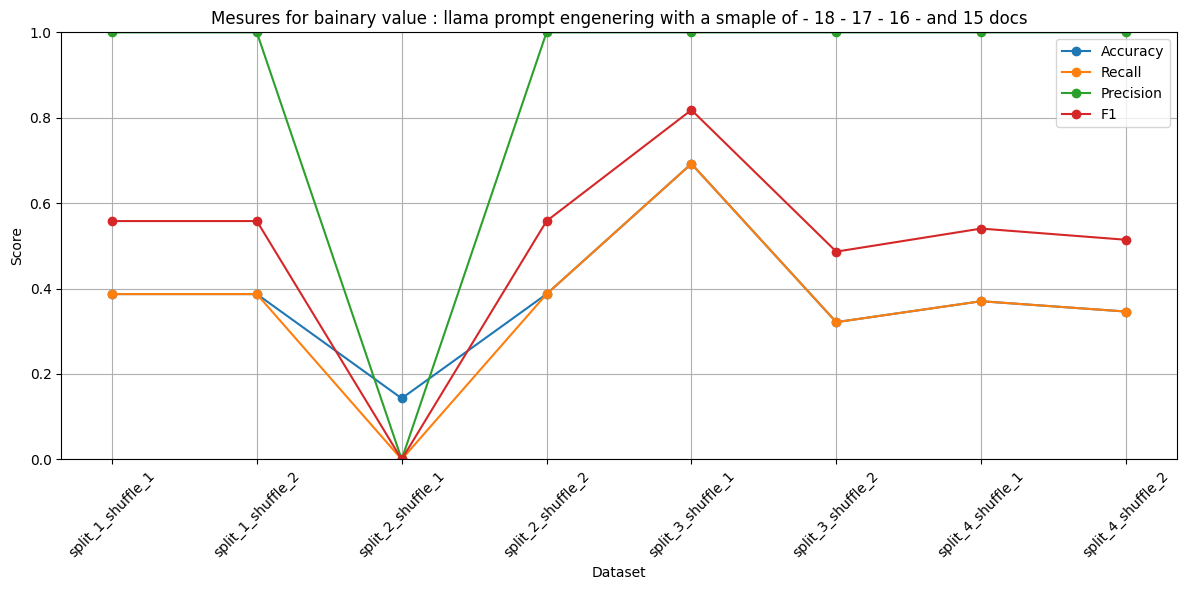

In [46]:
def plot_binary_mesures(splitted_mesures):
    # Clean up dataset names for readability
    splitted_mesures['Cleaned_Dataset'] = splitted_mesures['Dataset'].str.replace('extracted_', '', regex=False)

    metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(splitted_mesures['Cleaned_Dataset'], splitted_mesures[metric], marker='o', label=metric)

    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Mesures for bainary value : llama prompt engenering with a smaple of - 18 - 17 - 16 - and 15 docs')
    plt.grid() 
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_binary_mesures(splitted_mesures)

### Multi class values 
Exparimenter
Basically it's when the selected column can be more then 2 values (non binary), i think it can work with allocation (binary values) but i still did a separate case for it just in case

In [84]:
def truePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of true positives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"True Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falsePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of false positives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} != '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"False Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falseNegativesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False nergatives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of false negatives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    FN_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} != '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"False negatives for {value}: {row}")
            FN_count.append(row)
    
    conn.commit()
    conn.close()
    return FN_count

def trueNegativesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of True negatives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    Args:
        conn (str): The path to the SQLite database.
        gt (str): The name of the ground truth table.
        extracted (str): The name of the extracted data table.
        column (str): The column to check for the positive value. Default is 'Experimenter'.
        values (list): The list of values to check for in the specified column. Default is ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'].
    Returns:
        list: A list of counts of true negatives for each value in the specified column.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TN_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} != '{value}' AND ext.{column} != '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            #print(f"True Negatives for {value}: {row}")
            TN_count.append(row)
    
    conn.commit()
    conn.close()
    return TN_count

In [ ]:
##### TODO : use a function instead to group all this ######
TPE = truePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter') 
TPE_sum = sum(TPE)/len(TPE)
#print("Sum of TPE:", TPE_sum)
FPE = falsePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FPE_sum = sum(FPE)/len(FPE)
#print("Sum of FPE:", FPE_sum)
FNE = falseNegativesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FNE_sum = sum(FNE)/len(FNE)
#print("Sum of FNE:", FNE_sum)
TNE = trueNegativesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
TNE_sum = sum(TNE)/ len(TNE)

calculateMesures(TPE_sum, FPE_sum, FNE_sum, TNE_sum)

Sum of TPE: 0.0
Sum of FPE: 0.0
Sum of FNE: 0.0


{'Accuracy': 0, 'Recall': 0, 'Precision': 0, 'F1': 0}

In [ ]:
# Loop through each extracted data set and calculate the metrics for Experimenter
for ext in ext_splitted:
    TP = truePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), 'Experimenter')
    FP = falsePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), 'Experimenter')
    FN = falseNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), 'Experimenter')
    TN = trueNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), 'Experimenter')
    
    metrics = calculateMesures((sum(TP)/len(TP)), (sum(FP)/len(FP)), (sum(FN)/len(FN)), (sum(TN)/len(TN)))
    
    metrics_df = pd.DataFrame([metrics])
    metrics_df.index = [os.path.basename(ext['dir'])]
    print(metrics_df)

                             Accuracy  Recall  Precision      F1
extracted_split_1_shuffle_1    0.5333  0.0667     0.0667  0.0667
                             Accuracy  Recall  Precision      F1
extracted_split_1_shuffle_2    0.5333  0.0667     0.0667  0.0667
                             Accuracy  Recall  Precision      F1
extracted_split_2_shuffle_1    0.6923  0.3846     0.3846  0.3846
                             Accuracy  Recall  Precision   F1
extracted_split_2_shuffle_2       0.6     0.2        0.2  0.2
                             Accuracy  Recall  Precision      F1
extracted_split_3_shuffle_1    0.6667  0.3333     0.3333  0.3333
                             Accuracy  Recall  Precision      F1
extracted_split_3_shuffle_2     0.537  0.0741     0.0741  0.0741
                             Accuracy  Recall  Precision      F1
extracted_split_4_shuffle_1    0.6154  0.2308     0.2308  0.2308
                             Accuracy  Recall  Precision      F1
extracted_split_4_shuffle_2    

In [87]:
def calculateMulticlassMesures(ext_splitted, gt_table):    
    metrics_results = []
    value = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']
    for ext in ext_splitted:
        # Use correct argument order: column name then value list
        TP = truePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        FP = falsePositivesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        FN = falseNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        TN = trueNegativesExperimenter('content/database.db', gt_table, os.path.basename(ext['dir']), column='Experimenter', values=value)
        # Sum the results for overall metrics
        metrics = calculateMesures(
            sum(TP) / len(TP) if len(TP) else 0,
            sum(FP) / len(FP) if len(FP) else 0,
            sum(FN) / len(FN) if len(FN) else 0,
            sum(TN) / len(TN) if len(TN) else 0
        )
        metrics_results.append({
            'Dataset': os.path.basename(ext['dir']),
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            **metrics
        })

    metrics_df = pd.DataFrame(metrics_results)
    print(metrics_df)

metrics_df = calculateMulticlassMesures(ext_splitted, gt_table)

                       Dataset            TP             FP             FN  \
0  extracted_split_1_shuffle_1  [0, 0, 2, 0]  [0, 0, 28, 0]  [22, 6, 0, 0]   
1  extracted_split_1_shuffle_2  [0, 0, 2, 0]  [0, 0, 28, 0]  [22, 6, 0, 0]   
2  extracted_split_2_shuffle_1  [5, 0, 0, 0]   [8, 0, 0, 0]   [0, 6, 2, 0]   
3  extracted_split_2_shuffle_2  [0, 6, 0, 0]  [0, 24, 0, 0]  [22, 0, 2, 0]   
4  extracted_split_3_shuffle_1  [4, 0, 0, 0]   [8, 0, 0, 0]   [0, 6, 2, 0]   
5  extracted_split_3_shuffle_2  [0, 0, 2, 0]  [0, 0, 25, 0]  [19, 6, 0, 0]   
6  extracted_split_4_shuffle_1  [0, 6, 0, 0]  [0, 20, 0, 0]  [18, 0, 2, 0]   
7  extracted_split_4_shuffle_2  [0, 0, 2, 0]  [0, 0, 24, 0]  [18, 6, 0, 0]   

               TN  Accuracy  Recall  Precision      F1  
0  [8, 24, 0, 30]    0.5333  0.0667     0.0667  0.0667  
1  [8, 24, 0, 30]    0.5333  0.0667     0.0667  0.0667  
2  [0, 7, 11, 13]    0.6923  0.3846     0.3846  0.3846  
3  [8, 0, 28, 30]    0.6000  0.2000     0.2000  0.2000  
4  [0, 6, 10

In [88]:
import matplotlib.pyplot as plt

def plot_multiClass_metrics(metrics_df):
    metrics_df['Dataset'] = metrics_df['Dataset'].str.replace('extracted_', '', regex=False)
    metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(metrics_df['Dataset'], metrics_df[metric], marker='o', label=metric)

    plt.xlabel('shuffled data')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Mesures for Experimenter (multi-class)')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot_multiClass_metrics(metrics_df)

In [89]:
#provided by Anna 
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

## Useful queries 
i'm just testing things out i don't really know what they want

In [90]:
def distributionOfExpByAllocation(conn, gt, ext):
    '''. Distribution of Experimenter Types by Allocation
        Sees how Experimenter types are distributed for each Allocation value in ground truth:
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    cursor.execute(f"""
                    SELECT Allocation, Experimenter, COUNT(*) AS Count
                    FROM {gt}
                    GROUP BY Allocation, Experimenter
                    ORDER BY Allocation, Count DESC; """)
    test_table = cursor.fetchall()
    print("Distribution of Experimenter Types by Allocation")
    print("in the ground truth table:")
    for row in test_table:
        print(row)
    
    cursor.execute(f"""
                    SELECT Allocation, Experimenter, COUNT(*) AS Count
                    FROM {ext}
                    GROUP BY Allocation, Experimenter
                    ORDER BY Allocation, Count DESC; """)
    test_table = cursor.fetchall()
    print("in the extracted table:")
    for row in test_table:
        print(row)
    
    conn.commit()
    conn.close()

In [91]:
distributionOfExpByAllocation('content/database.db', gt_table, extracted_table)

Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Non-random', 'Teacher', 1)
('Random', 'Researcher', 7)
('Random', 'Teacher', 6)
('Random', 'Parent', 3)
('Researcher', 'Lefebvre et al. - 2011 - Enhancing vocabulary', 1)
('Teacher', 'Yeh and Connell - 2008 - Effects of rhyming', 1)


In [92]:
def distributionOfExpByAllocationForEach(ext_splitted, gt_table):
    for ext in ext_splitted:
        distributionOfExpByAllocation('content/database.db', gt_table, os.path.basename(ext['dir']))

distributionOfExpByAllocationForEach(ext_splitted, gt_table)

Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Random', 'Researcher', 18)
Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 111)
('Random', 'Teacher', 81)
('Random', 'Researcher', 40)
('Random', 'Combined - Teacher and Parent', 24)
('Random', None, 11)
in the extracted table:
('Random', 'Researcher', 18)
Distribution of Experimenter Types by Allocation
in the ground truth table:
('Non-random', 'Teacher', 30)
('Non-random', 'Researcher', 11)
('Non-random', None, 6)
('Non-random', 'Parent', 2)
('Random', 'Parent', 

In [93]:
def Studies_with_missing_data(conn, gt, ext):
    '''Find studies present in both tables but with missing (NULL or empty) values in key columns:
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
                    SELECT {gt}.Study, {gt}.Allocation AS GT_Allocation, {ext}.Allocation AS EXT_Allocation,
                    {gt}.Experimenter AS GT_Experimenter, {ext}.Experimenter AS EXT_Experimenter
                    FROM {gt}
                    JOIN {ext} ON {gt}.Study = {ext}.Study
                    WHERE {ext}.Allocation IS NULL
                        OR {ext}.Experimenter IS NULL
                        OR {ext}.Allocation = ''
                        OR {ext}.Experimenter = ''; """)
    test_table = cursor.fetchall()
    if not test_table:
        print("No studies with missing data found.")

    else : 
        print("Studies with Missing Data : ")
        for row in test_table:
            print(row)
    
    conn.commit()
    conn.close()

In [97]:
Studies_with_missing_data('content/database.db', gt_table, extracted_table)

No studies with missing data found.


In [101]:
def DistributionOfCathegories(conn, gt, ext, column = 'Allocation', cathegory = ['Random', 'Non-random']):
    '''Distribution of Categories in Ground Truth and Extracted Data
        Compares the distribution of categories in the ground truth and extracted data.
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()

    for cat in cathegory:
        cursor.execute(f"""
                        SELECT COUNT(*) FROM {gt} join {ext} ON {gt}.Study = {ext}.Study
                        WHERE {gt}.{column} = '{cat}';
                        """)
        gt_count = cursor.fetchone()[0] 
        
        cursor.execute(f"""
                        SELECT COUNT(*) FROM {ext} 
                        WHERE {column} = '{cat}';
                        """)
        ext_count = cursor.fetchone()[0]
        
        print(f"Category '{cat}': Ground Truth Count: {gt_count}, Extracted Count: {ext_count}")
    
    conn.commit()
    conn.close()

def plotDistributionByCathegory(gt_count, ext_count) :
    '''bar plot of the distribution of categories in the ground truth and extracted data.'''

    ##### place holder for the plot #####


In [102]:
DistributionOfCathegories('content/database.db', gt_table, extracted_table, 'Allocation', ['Random', 'Non-random'])  
DistributionOfCathegories('content/database.db', gt_table, extracted_table, 'Experimenter', ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent'])

Category 'Random': Ground Truth Count: 0, Extracted Count: 16
Category 'Non-random': Ground Truth Count: 0, Extracted Count: 1
Category 'Teacher': Ground Truth Count: 0, Extracted Count: 7
Category 'Parent': Ground Truth Count: 0, Extracted Count: 3
Category 'Researcher': Ground Truth Count: 0, Extracted Count: 7
Category 'Combined - Teacher and Parent': Ground Truth Count: 0, Extracted Count: 0


In [103]:
def ditributionCatAll(conn, gt, extracted, column = 'Allocation', cathegory = ['Random', 'Non-random']):
    '''Distribution of Categories in Ground Truth and Extracted Data for each extracted data set.
        Compares the distribution of categories in the ground truth and extracted data.
    '''
    for ext in extracted:
        print(f"Distribution for {os.path.basename(ext['dir'])}:")
        DistributionOfCathegories(conn, gt, os.path.basename(ext['dir']), column, cathegory)

In [104]:
ditributionCatAll('content/database.db', gt_table, ext_splitted, 'Allocation', ['Random', 'Non-random'])

Distribution for extracted_split_1_shuffle_1:
Category 'Random': Ground Truth Count: 12, Extracted Count: 18
Category 'Non-random': Ground Truth Count: 19, Extracted Count: 0
Distribution for extracted_split_1_shuffle_2:
Category 'Random': Ground Truth Count: 12, Extracted Count: 18
Category 'Non-random': Ground Truth Count: 19, Extracted Count: 0
Distribution for extracted_split_2_shuffle_1:
Category 'Random': Ground Truth Count: 12, Extracted Count: 0
Category 'Non-random': Ground Truth Count: 2, Extracted Count: 17
Distribution for extracted_split_2_shuffle_2:
Category 'Random': Ground Truth Count: 12, Extracted Count: 17
Category 'Non-random': Ground Truth Count: 19, Extracted Count: 0
Distribution for extracted_split_3_shuffle_1:
Category 'Random': Ground Truth Count: 9, Extracted Count: 16
Category 'Non-random': Ground Truth Count: 4, Extracted Count: 0
Distribution for extracted_split_3_shuffle_2:
Category 'Random': Ground Truth Count: 9, Extracted Count: 16
Category 'Non-random

In [105]:
def articals_with_the_most_studies(conn, table):
    
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT Study, COUNT(*) AS count
        FROM Ground_truth
        GROUP BY Study
        ORDER BY count DESC
        LIMIT 10;
    """)

    top_studies = cursor.fetchall()
    print("Top 10 studies with the most entries in Ground Truth:")
    #convert the results to a DataFrame for prettier display
    top_studies_df = pd.DataFrame(top_studies, columns=['Study', 'Count'])
    print(top_studies_df.to_string(index=False))
    
    conn.commit()
    conn.close()

articals_with_the_most_studies('content/database.db', gt_table)

Top 10 studies with the most entries in Ground Truth:
                      Study  Count
      Levin and Aram (2012)     42
 Lonigan & Whitehurst, 1998     18
             Vaquero (2014)     16
          Bianco et al 2010     15
    Whitehurst et al, 1994a     14
           Elmonayer (2013)     13
   Wing-Yin Chow et al 2008     12
Crain-Thoreson & Dale, 1999     12
    Whitehurst et al, 1994b     11
  Lever and Senechal (2011)      9


In [ ]:
def allocationByYear(conn, table):
    
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT
        SUBSTR(Study, -4, 4) AS year,
        Allocation,
        COUNT(*) AS count
        FROM {table}
        WHERE SUBSTR(Study, -4, 4) GLOB '[0-9][0-9][0-9][0-9]'
        GROUP BY year, Allocation
        ORDER BY year, Allocation;
    """)
    ground_truth_yearly_counts = cursor.fetchall()
    # Convert the results to a DataFrame for prettier display
    yearly_df = pd.DataFrame(ground_truth_yearly_counts, columns=['Year', 'Allocation', 'Count'])
    print("Allocation types per year:")
    print(yearly_df.to_string(index=False))
    
    conn.commit()
    conn.close()
#it's not pretty and ureadable imo, find a better way to display it maybe with a plot
allocationByYear('content/database.db', gt_table)

Allocation types per year:
Year Allocation  Count
1989     Random      1
1990     Random      4
1992     Random      2
1997 Non-random      2
1998     Random     18
1999     Random     23
2000 Non-random      2
2002 Non-random      8
2003     Random      9
2004 Non-random      5
2004     Random      2
2005 Non-random      4
2007     Random      4
2008     Random     29
2010 Non-random     17
2010     Random     18
2011     Random      6
2016     Random      3
2017 Non-random      2
2017     Random     14


In [110]:
def MostFrequentPairs(conn, table):
    
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""SELECT Allocation, Experimenter, COUNT(*) AS count
        FROM {table}
        GROUP BY Allocation, Experimenter
        ORDER BY count DESC;
                   """)
    
    ground_truth_allocation_experimenter = cursor.fetchall()

    # Convert the results to a DataFrame for prettier display
    allocation_experimenter_df = pd.DataFrame(ground_truth_allocation_experimenter, columns=['Allocation', 'Experimenter', 'Count'])
    print("Most frequent (Allocation, Experimenter) pairs :")
    print(allocation_experimenter_df.to_string(index=False))
    
    conn.commit()
    conn.close()

print(MostFrequentPairs('content/database.db', gt_table))

Most frequent (Allocation, Experimenter) pairs :
Allocation                  Experimenter  Count
    Random                        Parent    111
    Random                       Teacher     81
    Random                    Researcher     40
Non-random                       Teacher     30
    Random Combined - Teacher and Parent     24
Non-random                    Researcher     11
    Random                          None     11
Non-random                          None      6
Non-random                        Parent      2
None


In [ ]:
def numberOfStudiesPerYear(conn, table):
    
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    ## maybe count the number of studies per year and the number of experiemnts per year beside it
    cursor.execute(f"""
        SELECT SUBSTR(Study, -4, 4) AS year,
        Study,
        COUNT(*) AS numberOfExperiments
        FROM Ground_truth
        WHERE SUBSTR(Study, -4, 4) GLOB '[0-9][0-9][0-9][0-9]'
        GROUP BY year, Study
        ORDER BY year, Study;
    """)
    ground_truth_experimenter_yearly_counts = cursor.fetchall()
    # Convert the results to a DataFrame for prettier display
    yearly_experimenter_df = pd.DataFrame(ground_truth_experimenter_yearly_counts, columns=['Year', 'Study', 'NumberOfExperiments'])
    print("Number of experiments per study for each year:")
    print(yearly_experimenter_df.to_string(index=False))
    
    conn.commit()
    conn.close()

In [ ]:
conn = sqlite3.connect('content/database.db')
cursor = conn.cursor()

cursor.execute(f"""
    SELECT Experimenter, COUNT(*) FROM Ground_truth GROUP BY Experimenter;
""")
gt_counts = cursor.fetchall()
print("Ground Truth Experimenter counts:")
for row in gt_counts:
    print(row)

cursor.execute(f"""
    SELECT Experimenter, COUNT(*) as count FROM extracted_split_2_shuffle_1 GROUP BY Experimenter;
""")
ext_counts = cursor.fetchall()
print("Extracted Experimenter counts:")
for row in ext_counts:
    print(row)

conn.commit()
conn.close()

In [ ]:
cursor.execute(f"""
    SELECT gt.Study, gt.Allocation as gt_alloc, ext.Allocation as ext_alloc
    FROM Ground_truth gt
    JOIN Extracted ext ON gt.Study = ext.Study
    WHERE gt.Allocation != ext.Allocation;

    SELECT gt.Study, gt.Experimenter as gt_exp, ext.Experimenter as ext_exp
    FROM Ground_truth gt
    JOIN Extracted ext ON gt.Study = ext.Study
    WHERE gt.Experimenter != ext.Experimenter;
""")

## To do :
- test again the other written queries
- test with the multiple shots prompting (it's only done with the python code i should've started here)